<a href="https://colab.research.google.com/github/praneelseth/inspiritAIprojects/blob/master/Praneel_Seth_NN_ConscientiousCars_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


We work for CC: ConscientiousCars, where we help self-driving vehicles be more conscientious of their surroundings. Our cars have been very good at recognizing and avoiding humans. They haven't, however, been capable of recognizing dogs. Since dogs are man's best friend and will always be where we humans are, we want our cars to know if a dog is on the road in front of them and avoid the dog!

The first step to avoiding these cute puppies is **knowing if a puppy is in front of the car**. So today we will **build a detector that can tell when our car sees a dog or not**!



In [ ]:
#@title Run this to load some packages and data! { display-mode: "form" }
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from collections import Counter
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


def categorical_to_numpy(labels_in):
  labels = []
  for label in labels_in:
    if label == 'dog':
      labels.append(np.array([1, 0]))
    else:
      labels.append(np.array([0, 1]))
  return np.array(labels)

def one_hot_encoding(input):
  output = np.array(input)
  output = np.zeros((input.size, input.max()+1))
  output[np.arange(input.size),input] = 1

  return output


def load_data():
  # Run this cell to download our data into a file called 'cifar_data'
  !wget -O cifar_data https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%204%20_%205%20-%20Neural%20Networks%20_%20CNN/dogs_v_roads

  # now load the data from our cloud computer
  import pickle
  data_dict = pickle.load(open( "cifar_data", "rb" ));

  data   = data_dict['data']
  labels = data_dict['labels']

  return data, labels

def plot_one_image(data, labels, img_idx):
  from google.colab.patches import cv2_imshow
  import cv2
  import matplotlib.pyplot as plt
  my_img   = data[img_idx, :].squeeze().reshape([32,32,3]).copy()
  my_label = labels[img_idx]
  print('label: %s'%my_label)
  fig, ax = plt.subplots(1,1)

  img = ax.imshow(my_img.astype('uint8'), extent=[-1,1,-1,1])

  x_label_list = [0, 8, 16, 24, 32]
  y_label_list = [0, 8, 16, 24, 32]

  ax.set_xticks([-1, -0.5, 0, 0.5, 1])
  ax.set_yticks([-1, -0.5, 0, 0.5, 1])

  ax.set_xticklabels(x_label_list)
  ax.set_yticklabels(y_label_list)

  fig.show(img)

def CNNClassifier(num_epochs=30, layers=4, dropout=0.5):
  def create_model():
    model = Sequential()
    model.add(Reshape((32, 32, 3)))

    for i in range(layers):
      model.add(Conv2D(32, (3, 3), padding='same'))
      model.add(Activation('relu'))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.legacy.RMSprop(learning_rate=0.0001, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model
  return KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=10, verbose=2)

def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 7)
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

In this notebook, you'll:
- Explore the dogs vs. roads dataset
- Train a simple K-neighbors classifier for computer vision
- Train neural nets to tell dogs from roads
- Improve your model with convolutional neural networks!
- (Optional challenge) Use a saliency map to implement explainable AI

# Understanding our data

Our cars are very attentive and always have their eyes on the road.

Every second, they're streaming in data about the street, including video.

From this video data, we want our car to tell: is there 'road' or 'dog' in front of it?

Lucky for us, we have a dataset of dog and road images already prepared! Let's start by reading that *labeled* data in.


In [ ]:
# load our data
data, labels = load_data()

--2023-06-09 14:55:14--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%204%20_%205%20-%20Neural%20Networks%20_%20CNN/dogs_v_roads
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.111.128, 142.251.16.128, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3689015 (3.5M) [application/octet-stream]
Saving to: ‘cifar_data’

cifar_data          100%[===================>]   3.52M  --.-KB/s    in 0.04s   

2023-06-09 14:55:14 (81.4 MB/s) - ‘cifar_data’ saved [3689015/3689015]



Let's look at an image of a dog!

Try changing the number below. What does it do?



label: dog


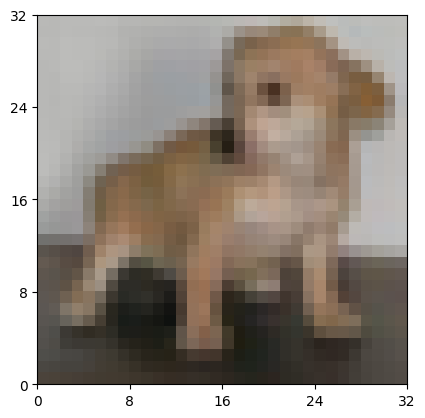

In [ ]:
plot_one_image(data, labels, 100) #change this number

**Discuss:** Why might we be using such blurry images?

Next, let's try a road image. Again, try changing the number:

label: road


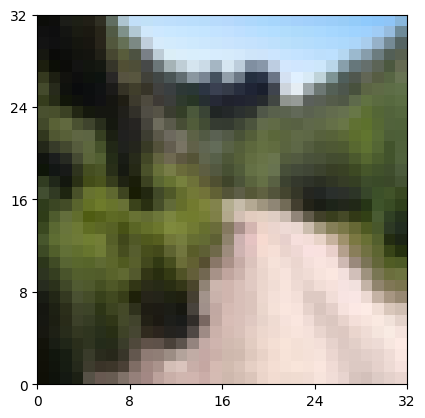

In [ ]:
plot_one_image(data, labels, 700) #change this number

How many images do we have?

In [ ]:
print (len(data))
print(Counter(labels))

1200
Counter({'dog': 600, 'road': 600})


The dataset is organized such that there are 600 images of dogs and 600 images of roads.

#### Optional Exercise: Examining More Images

**Look at a few more images of both classes.**

Try using a `for` loop to look at 5 images!

label: dog
label: dog
label: dog
label: road
label: road


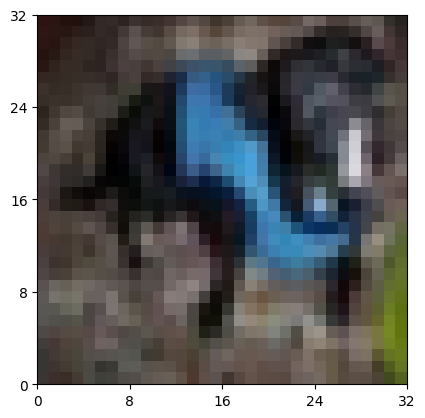

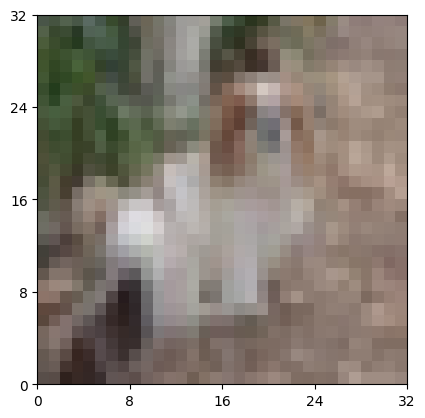

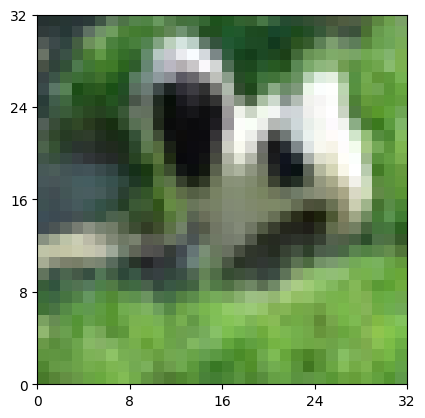

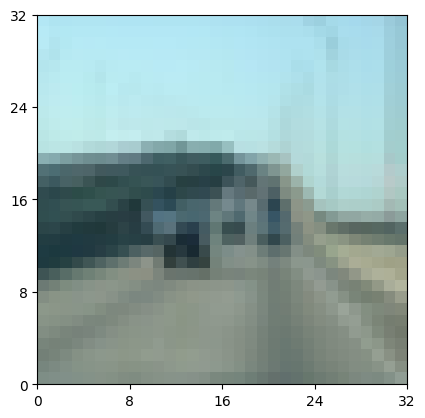

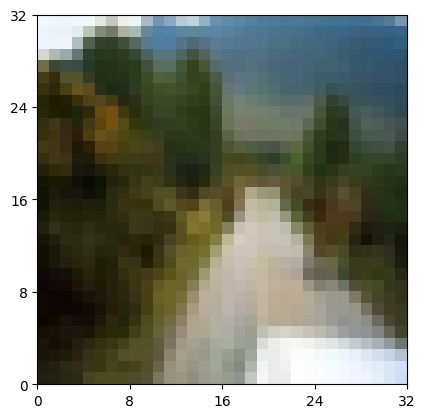

In [ ]:
### YOUR CODE HERE
for i in range(5):
  plot_one_image(data, labels, i*180)

### END CODE

##Understanding our Data Representation

In an image each pixel is denoted by 3 numbers that represent the intensity value of that pixel (0 - 255) for each color channel (R, G, and B). Below we
see a list of numbers for each image that represent the intensity values.


In [ ]:
print('One image looks like: ')
print(data[0])
print("Length of list: ", len(data[0]))

One image looks like: 
[45 20 19 ... 83 99 31]
Length of list:  3072


**Discuss:** What does each number mean? Can you explain the length of the list?

In [ ]:
#@title Exercise: Fill in the correct values for each image's height, width, and number of color channels:

img_height =  32#@param {type:"integer"}
img_width =  32#@param {type:"integer"}
color_channels =  3#@param {type:"integer"}

if img_height == 32 and img_width == 32 and color_channels == 3:
  print("Correct!")
  print ("Each image is", img_height, 'x', img_width, 'pixels.')
  print ("Each pixel has", color_channels, "channels for red, green, blue.")
  print ("This gives a total of", img_height * img_width * color_channels, "intensity values per image.")
else:
  print("Those aren't quite the values.")
  print("Your values give a total of", img_height * img_width * color_channels, "intensity values per image.")
  print("Discuss with your group and try again!")



Correct!
Each image is 32 x 32 pixels.
Each pixel has 3 channels for red, green, blue.
This gives a total of 3072 intensity values per image.


We use these values as **inputs** to predict an **output** label: 'dog' or 'road'!

Here's what our entire dataset looks like:

In [ ]:
print ('Data shape:', data.shape)
print ('Data:', data)

Data shape: (1200, 3072)
Data: [[ 45  20  19 ...  83  99  31]
 [101 114  35 ... 155 134  91]
 [213 221 221 ... 139  58  47]
 ...
 [126 174 202 ... 124 128 129]
 [191 232 240 ...  74  93  81]
 [237 248 254 ...  45  56  10]]


#A Simple Machine Learner

We want to create a machine learning model that can tell us whether a new image is either a dog or a road.

We will give our model a training manual of data and labels that it will study or train on.

We then check how well our model is doing on a test, where it is given data and told to predict their labels.


##Building a KNN##

Let's start by using the `KNeighborsClassifier` model.

**Playground:** Explore [this demo](http://vision.stanford.edu/teaching/cs231n-demos/knn/) to understand what the KNN model is doing!

**Exercise:** Below, please build, train, and measure the accuracy of your own KNN model. Experiment with changing the number of neighbors!


In [ ]:
# Preparing data and create training and test inputs and labels
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, labels, test_size=0.2, random_state=1)

### YOUR CODE HERE

# Initialize our model
knn_model = KNeighborsClassifier(17) # Change this!

# Train our model
knn_model.fit(X_train, y_train)

# Test our model
y_pred = knn_model.predict(X_test)

# Print the score on the testing data
accuracy = accuracy_score(y_test, y_pred)
print (accuracy)

### END CODE

0.8166666666666667


**(Optional):** After you've built your KNN model, remove ```random_state=1``` and re-run the cells above. How does removing ```random_state=1``` affect your accuracy? Why?

##Predicting on images

We can use our trained model to predict whether our car is seeing a `dog` or `road`. Let's try this out - experiment with different images!


label: dog
prediction: dog


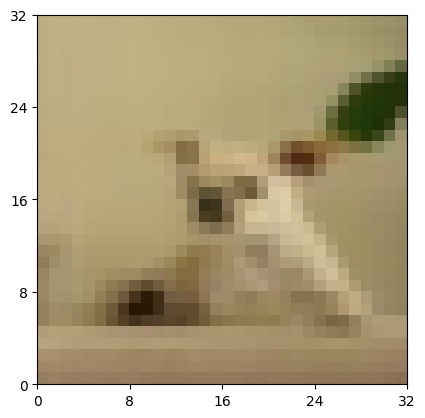

In [ ]:
# Specify which image you want to show
image_id = 200 #Change this!

# Visualize the image
plot_one_image(X_test, y_test, image_id)

# Use the model to predict what this might be and print it
print('prediction:', knn_model.predict([X_test[image_id]])[0])

## Choosing a value of k

**Exercise** Determine the optimal value of "K" for our data. Use a for-loop to loop through different values of "K". In particular, *at the very least* try K = 1, 3, 5, 10, 20, and 30. For each of these values of "K", define a new KNN model, train it, and evaluate the accuracy.

In [ ]:
### YOUR CODE HERE
k_values = [14]
for k in k_values:
  knn_model = KNeighborsClassifier(k)
  knn_model.fit(X_train, y_train)
  y_pred = knn_model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print('Accuracy score for [' + str(k) + '] neighbors: ' + str(accuracy))
### END CODE

Accuracy score for [14] neighbors: 0.8458333333333333


**Discuss:** What are the advantages and disadvantages of using a bigger vs. smaller **k**? What is the optimal value?

## (Optional) Understanding our mistakes

Our classifications are OK, but are they good enough for our conscientious cars?

Let's put on our detective hats to determine the root causes of the incorrect classifications!

**Exercise:** Below, please print out 4 images of true positives, 4 images of true negatives, 4 images of false positives, and 4 images of false negatives. What are the reasons for failure (both for false positives and false negatives)?

TRUE POSITIVES
label: dog
label: dog
label: dog
label: dog


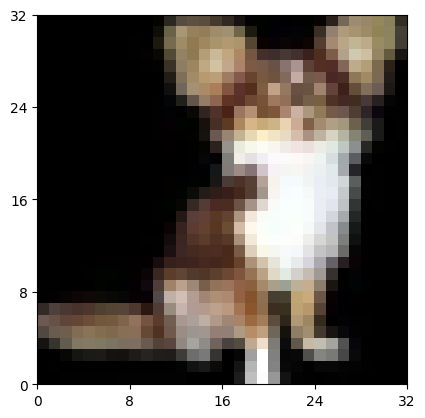

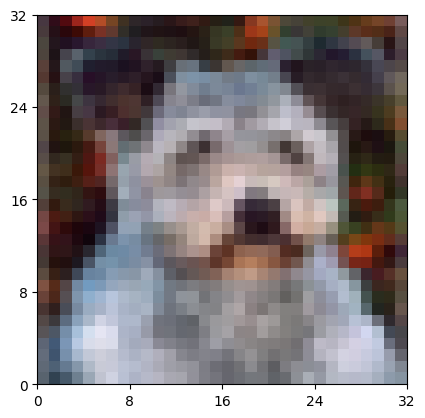

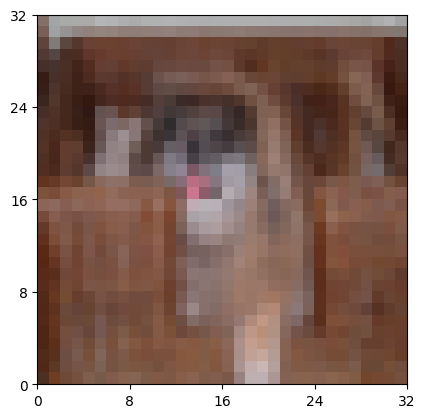

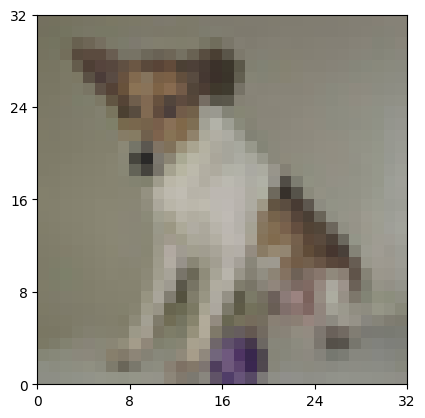

In [ ]:
#True Positives (code provided)
tp_count = 0
print ("TRUE POSITIVES")
i = 0
while tp_count < 4 and i < len(X_test):
  prediction = knn_model.predict([X_test[i]])[0]
  if prediction == y_test[i] and prediction == 'dog':
    plot_one_image(X_test, y_test, i)
    tp_count += 1
  i += 1

#False Positives
#YOUR CODE HERE

#True Negatives
#YOUR CODE HERE

#False Negatives
#YOUR CODE HERE

**Discuss:** What patterns did you notice? What are some reasons that the model makes mistakes?

#Neural Networks
Now, let's create some new models using neural networks!

You can play around with [TensorFlow Playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.62283&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&learningRate_hide=true&batchSize_hide=true&stepButton_hide=true&activation_hide=true) to get a feel for how neural nets work.

To build a simple neural network, we use `MLPClassifier` from scikit-learn. We will play with the **number of neurons** and the **number of hidden layers** to adjust the complexity of our model, just like we did in Playground!

**Example 1:**
Here's how we create a neural network with 1 hidden layer of 3 neurons.

`nnet = MLPClassifier(hidden_layer_sizes=(3)) `

**Example 2:**

Here's how we create a neural network with 2 hidden layers: one of 3 neurons and one of 4 neurons.

`nnet = MLPClassifier(hidden_layer_sizes=(3, 4)) `

**Discuss:** How might you build a neural network with 3 hidden layers? Run the code below and modify it!

In [ ]:
# Create and train our multi layer perceptron model
nnet = MLPClassifier(hidden_layer_sizes=(3, 4, 5), random_state=1, max_iter=10000000)  ## How many hidden layers? How many neurons does this have?
nnet.fit(X_train, y_train)

# Predict what the classes are based on the testing data
predictions = nnet.predict(X_test)

# Print the score on the testing data
print("MLP Testing Accuracy:")
print(accuracy_score(y_test, predictions)*100)

MLP Testing Accuracy:
84.16666666666667


**How well did your neural network perform?**

Multilayer perceptrons are more complex models and it can be difficult to find the right "settings" for them. It takes some trial and error!

**Exercise: try the following out and see how well you can get your network to do!**
* Train a 1 layer, 10 neuron network for practice
* Change the number of neurons and/or add layers to see how well you can do
* Increase or decrease the number of iterations

In [ ]:
#YOUR CODE HERE
nnet = MLPClassifier(hidden_layer_sizes=(3, 4, 5), random_state=1, max_iter=30000000)
nnet.fit(X_train, y_train)

predictions = nnet.predict(X_test)

print("MLP Testing Accuracy: ")
print(accuracy_score(y_test, predictions)*100)

MLP Testing Accuracy: 
87.91666666666667


###Automating our Experiments

**Exercise:** Similar to what you did for KNNs, use a for loop to automate your investigation. Explore different numbers of hidden layers, the size of the hidden layers, and the number of iterations! How well can you get your network performing?

In [ ]:
### YOUR CODE HERE

### END CODE

# Models for Vision: Convolutional Neural Networks
There is a famous type of neural network known as convolutional neural networks (CNNs). These types of neural networks work particularly well on problems to do with computer vision. Let's try one out!

###Training Your CNN
To load up a simple CNN on scikit-learn, just run:

`cnn = CNNClassifier(num_epochs=N)`

The `num_epochs` represents how many times the neural network passes through the training dataset.

We'll need to change our data to floats (decimal numbers).

**Exercise:** Please train and test your CNN below!

In [ ]:
# convert our data to floats for our CNN
X_train = X_train.astype(float)
X_test = X_test.astype(float)

### YOUR CODE HERE
# Create and train our cnn
cnn = CNNClassifier(num_epochs=100)
cnn.fit(X_train, y_train)

# Predict what the classes are based on the testing data
y_pred = cnn.predict(X_test)

# Print the score on the testing data
print(accuracy_score(y_test, y_pred))

### END CODE

<ipython-input-2-b8babc18f85f>:111: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  return KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=10, verbose=2)


Epoch 1/100
96/96 - 9s - loss: 1.9627 - accuracy: 0.6427 - 9s/epoch - 97ms/step
Epoch 2/100
96/96 - 7s - loss: 0.4631 - accuracy: 0.8104 - 7s/epoch - 72ms/step
Epoch 3/100
96/96 - 11s - loss: 0.3046 - accuracy: 0.8719 - 11s/epoch - 114ms/step
Epoch 4/100


KeyboardInterrupt: ignored

**Discuss: Is this CNN good enough to use in practice?**

CNNs typically perform better than basic Neural Networks on vision problems - but like basic Neural Networks, they aren't always consistent in their results and are sensitive to a number of factors.

If you're interested in learning more about CNNs, spend some time exploring the [CNN Explainer](https://poloclub.github.io/cnn-explainer/)!

**Report to the class your highest model accuracy.**

**Bonus Question:** Each of you might see a different max accuracy. Can you think of why that might be?


## Training and Validation Curves

An important aspect of training neural networks is to prevent overfitting. **How do you know when your model is overfitting?**

To plot our model's history, we can train it with
```
history = model.fit(X_train, categorical_to_numpy(y_train), validation_data=(X_test, categorical_to_numpy(y_test)))
```

and then use
```
plot_acc(history)
```
Don't forget to change ```model``` to be the name of your model!

**Exercise:** Train a CNN model and plot a train vs. test curve.

**After how many epochs does the model begin to overfit?** Overfitting occurs when the validation accuracy starts to drop below the training accuracy.

In [ ]:
### YOUR CODE HERE
history = cnn.fit(X_train, categorical_to_numpy(y_train), validation_data=(X_test, categorical_to_numpy(y_test)))
plot_acc(history)
### END CODE

Epoch 1/100
96/96 - 9s - loss: 3.3349 - accuracy: 0.6073 - val_loss: 0.3525 - val_accuracy: 0.8917 - 9s/epoch - 93ms/step
Epoch 2/100


KeyboardInterrupt: ignored

### Hopefully your CNN worked *very* well! We want to keep the doggos as safe as they can be.

![](https://images.pexels.com/photos/316/black-and-white-animal-dog-pet.jpg?auto=compress&cs=tinysrgb&dpr=2&h=650&w=940)

# Challenge Exercise: Explainability through Saliency Maps

Neural networks have achieved incredible results in many fields. But they have a big problem: it’s very difficult to explain exactly why a neural network makes the decisions it does. This makes it difficult to trust them in high-stakes applications like medicine, self-driving cars, and criminal justice - would you trust an AI that diagnosed you with a disease, but couldn’t explain why?

Other classifiers are much more explainable:

*   With logistic regression, we can see the coefficient (importance) attached to each input feature.
*   With a decision tree, we can trace a particular decision down the tree.
*   With KNN, we can examine the nearby neighbors.

Our CNN, above, works well. For example, let's try choosing an image from our dataset and classifying it.

In [ ]:
image_index = 210 #pick any image you'd like
input_image = X_test[image_index]
print (input_image.shape)
print (input_image) #How many numbers are there? What does each represent?

plt.imshow(input_image.reshape(32,32,3).astype(int))
plt.show()

print ('Classification:')
print(cnn.predict(np.array([input_image]))) #Our predict function expects a 2D array.
#0 means dog, 1 means road

NameError: ignored

But why did the CNN reach that decision? It’s really hard to give a clear answer! The CNN relies on multiplying input features by the weights it has set. You can print out and look at the hundreds of weights:


In [ ]:
#Warning: expect a large output!
for layer_weights in history.model.weights:
  print (layer_weights)

NameError: ignored

Unfortunately, that probably didn’t help you make a useful explanation.

Researchers are currently studying ways to make neural networks more explainable. One approach is using **saliency maps** to figure out the saliency (importance) of each individual pixel. Check out a demo [here](https://lrpserver.hhi.fraunhofer.de/image-classification). Intuitively, we're trying to understand the neural network by tracking what it "pays attention" to, in the same way that psychologists study babies' cognition by [tracking what babies look at](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3259733/).

In this exercise, we're going to build a simple version of a saliency map for the image you chose above. We'll see what pixels were most important in helping the network make its classification.

To do this, we'll investigate the effects of changing each pixel a little bit. If changing a particular pixel changes the result a lot, we conclude that pixel must be important for classifying. If changing that pixel doesn't change the result, we conclude that pixel is unimportant.


We're going to use the raw predicted probabilities, rather than the final classification.

In [ ]:
pred = cnn.predict_proba(np.array([input_image])) #What does each number mean?
print (pred)
dog_prob = pred[0][0] #This is the probability we'll use (if we know dog prob, we know the classification)

print ('Probability of dog:')
print (dog_prob)

1/1 [==============================] - 0s 152ms/step
[[0.98914695 0.01085301]]
Probability of dog:
0.98914695


Now, we need to calculate the saliency for each pixel (really, each R/G/B value). The core idea is that a pixel's saliency is the average value of

 $D = |\frac{\Delta probability}{\Delta pixel}|$

 where $\Delta$ is the amount of change. If a small change in the pixel value results in a large change in the probability (either up or down), we know this pixel is important. If you've seen derivatives in calculus, this idea should feel familiar.

Here's the game plan:

*   Consider each pixel value in turn: R, G, B, then the next pixel.
*   Make a copy of the image array before you change anything!
*   Make the pixel value larger or smaller by various amounts. Each time, find the CNN's prediction with the changed value, and calculate the value of D.
*   Repeat the previous step a few times, and calculate the pixel's saliency: the average value of D.
*   Store the saliency of each pixel in a list, so that we can visualize it later.

Try it below! (Warning: this code might be very slow. As a further challenge, try to speed it up!)


In [ ]:
saliencies = [] #eventually, will be the same size as input_image

saliency = 0
for index, pixel in enumerate(input_image):
  #index counts up from 0, pixel is between 0 and 255

  #if index%100 == 0: #will track progress - this might take a while
  print (index)

  changed_input = input_image.copy() #make sure not to change the original input_image!

  #YOUR CODE HERE:
  #In changed_input, change the value of this pixel by some amount.
  change_variations = [50, 100]
  for change in change_variations:
    changeAmount = change;
    if (pixel < change):
      changeAmount *= 1;
    else:
      changeAmount *= -1;
    changed_input[index] += changeAmount;

    #Use the CNN to classify changed_input.
    pred = cnn.predict_proba(np.array([changed_input]))
    prob = pred[0][0] #This is the probability we'll use (if we know dog prob, we know the classification)

    #Calculate the value of D.
    d = (prob - dog_prob) / changeAmount

    #Repeat with various-size changes, and calculate saliency as the average D.
    saliency += d #Change this!

  saliency /= 5
  saliencies.append(saliency)

print (saliencies)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step
1406
1/1 [==============================] - 0s 24ms/step
1407
1/1 [==============================] - 0s 18ms/step
1408
1/1 [==============================] - 0s 23ms/step
1409
1/1 [==============================] - 0s 26ms/step
1410
1/1 [==============================] - 0s 19ms/step
1411
1/1 [==============================] - 0s 20ms/step
1412
1/1 [==============================] - 0s 20ms/step
1413
1/1 [==============================] - 0s 26ms/step
1414
1/1 [==============================] - 0s 24ms/step
1415
1/1 [==============================] - 0s 29ms/step
1416
1/1 [==============================] - 0s 23ms/step
1417
1/1 [==============================] - 0s 22ms/step
1418
1/1 [==============================] - 0s 19ms/step
1419
1/1 [==============================] - 0s 22ms/step
1420
1/1 [==============================] - 0s 23ms/step
1421
1/1 [==============================] 

You'll notice that your saliencies are probably very small values, since each individual pixel has a small effect on the output.
Here are the current min and max:

In [ ]:
sal_array = np.array(saliencies)
print (sal_array.min(), sal_array.max())
print (sal_array.shape)

-3.6574221093237074e-05 3.554951276242579e-05
(3072,)


To plot the saliencies, we need to do some arithmetic to transform them to a range of 0 to 1. Can you explain the function of each line?

In [ ]:
sal_array = np.array(saliencies)

#Can you perform this transformation in a single line of code?
sal_array = (sal_array - sal_array.min())/(sal_array - sal_array.min()).max()
print (sal_array.min(), sal_array.max())
print (sal_array.shape)

0.0 1.0
(3072,)


Finally, we can plot our saliency map!

If you're not getting great results, try experimenting with how much you're changing the pixel values.

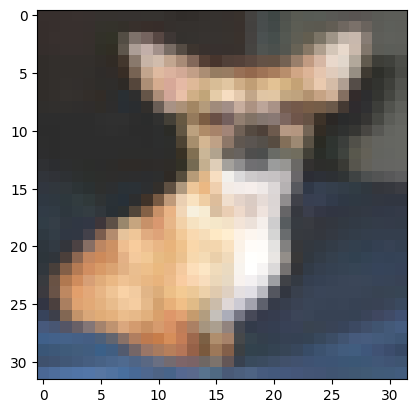

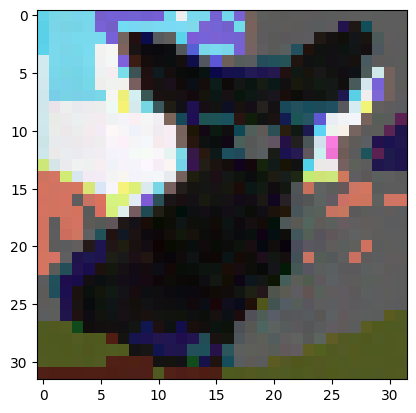

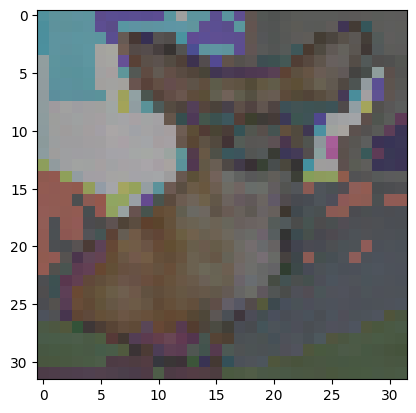

In [ ]:
#Plot our original image
plt.imshow(input_image.reshape(32,32,3).astype(int))
plt.show()

#Plot our saliency map: the brighter, the higher the saliency
plt.imshow(sal_array.reshape(32,32,3))
plt.show()

#Plot our saliency map superimposed on the image
plt.imshow(input_image.reshape(32,32,3).astype(int))
plt.imshow(sal_array.reshape(32,32,3),alpha=0.6)
plt.show()

We now have some insight into our neural network! We know which pixels matter in its decisions.

You can experiment with the definition of saliency we used above; you might come up with a better way to measure it!